# Dependencies

In [34]:
import scipy
from scipy.optimize import curve_fit
from scipy.io import wavfile
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import osascript
from gtts import gTTS 
from matplotlib import pylab
import os 
import pyaudio
import wave
import keyboard  # using module keyboard
import soundfile as sf
import math
import pyloudnorm as pyln
from sys import byteorder
from array import array
from struct import pack

# Constants

In [78]:
THRESHOLD = 100
CHUNK_SIZE = 2048
FORMAT = pyaudio.paInt16
RATE = 44100
AVG_STEP = 75
PERCENTILE = 70
BANDPASS_FREQ = [300, 3400]
CALIBRATION_VOLUME = 40

# Record Audio

#### Record from microphone

 Record a word or words from the microphone and return the data as an array of signed shorts.

Normalizes the audio, trims silence from the start and end, and pads with 0.5 seconds of 
blank sound to make sure VLC et al can play it without getting chopped off.

In [36]:
def record():
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 60:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

#     r = trim(r)
#     r = add_silence(r, 0.5)
    return sample_width, r

#### Save to wav file

In [37]:
def record_to_file(path):
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

#### Checks if input is silent based on threshold

In [38]:
def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

# Preprocessing

#### Trim input to remove silence at beginning and end

In [39]:
def trim(snd_data):
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)
            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

#### Pad with silence at beginning and end

In [40]:
def add_silence(snd_data, seconds):
    ""
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

#### Process wav input with highpass filter

In [41]:
def voice_input(voice_data):
    fs, data = wavfile.read(voice_data)
    data = butter_bandpass_filter(data, BANDPASS_FREQ[0], BANDPASS_FREQ[1], fs)
    return data, fs

#### Implement butter bandpass filter

In [42]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

# Loudness Algorithm

#### Get amplitude curve and apply regression on ITU-R BS.1770-4 loudness algorithm

In [43]:
def getting_loudness3(data, rate):
    plt.figure(0)
    plt.plot(data)
    
    # Average data by step size to percentile
    avg_data = np.percentile(data[:(len(data)//AVG_STEP)*AVG_STEP].reshape(-1,AVG_STEP),
                             PERCENTILE, axis=1)
    
    #apply hilbert envelope
    hilbert_transformed = np.abs(scipy.signal.hilbert(avg_data))

    #Smooth out hilbert 
    b, a = scipy.signal.ellip(4, 0.01, 120, 0.125)
    fgust = scipy.signal.filtfilt(b, a, hilbert_transformed, method="gust")
    plt.figure(1)
    plt.plot(avg_data)
    plt.plot(fgust)

    #remove silence 
    avg = np.mean(fgust)
    silenced = remove_silence_from(fgust, avg)
    plt.figure(2)
    plt.plot(silenced)
    data = [float(i) for i in silenced]
    data = np.array(data)

    # measure the loudness first 
    meter = pyln.Meter(rate/500) # create BS.1770 meter
    loudness = meter.integrated_loudness(data)
    print("lds: "+ str(loudness))
    #return the exponential regression
    return (loudness)

#### Remove silence before, after, and in-between voice data

In [44]:
def remove_silence_from(amplitudes, threshold):
    silenced = []
    for x in amplitudes:
        if x >= threshold:
            silenced.append(x)
    return silenced# Preprocessing

#### Regression converts loudness to scale 0 to 100 and adjusts for calibration offset

In [70]:
def regression(loudness, offset=0):
    return 2.1256619652039683 * loudness + 52.66548772500079 - offset

# Calibration

In [46]:
def get_offset(calib_loudness):
    return calib_loudness - CALIBRATION_VOLUME

# Response

#### Sets a new volume that is spoken at for the user

In [47]:
def reply(user_volume):
    speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
    print("speaker volume is " + str(speaker_volume))
    print("user volume is "+ str(user_volume))
    if(speaker_volume < user_volume):
        new_volume = speaker_volume + (((speaker_volume - user_volume)**2) /100)
    else:
        new_volume = speaker_volume - (((speaker_volume - user_volume)**2) /100)
    print("speaker new volume is " + str(new_volume))
    osascript.osascript("set volume output volume "+ str(new_volume)) 
    thing_to_say = 'hello your volume is at '+ str(int(new_volume))
    print(thing_to_say)
    os.system("say "+ thing_to_say)

# Main

Please speak at a normal room volume for calibration
lds: -1.1376969170659499
Calib loudness: -1
Calib loudness: 50
Offset: 20.247128660463886
please speak a word into the microphone
done - result written to demo.wav
lds: 7.647111489882888


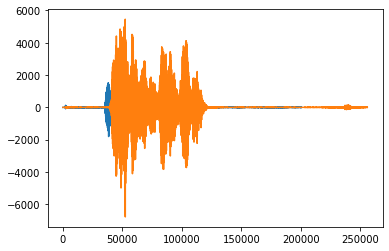

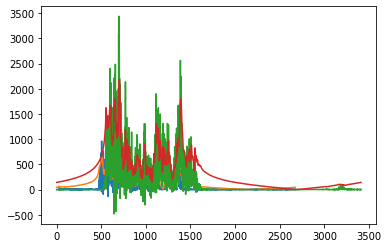

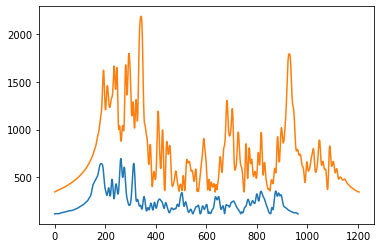

In [77]:
import time
if __name__ == '__main__':
    #calibration
    os.system("say "+ "Please speak at a normal room volume for calibration")
    print("Please speak at a normal room volume for calibration")
    record_to_file('calibrate.wav')
    data, rate = voice_input('calibrate.wav')
    calib_loudness = getting_loudness3(data, rate)
    print("Calib loudness: " + str(int(calib_loudness)))
    calib_loudness = regression(calib_loudness)
    print("Calib loudness: " + str(int(calib_loudness)))
    offset = get_offset(calib_loudness)
    print("Offset: " + str(offset))
    
    os.system("say "+ "Please speak into the microphone")
    print("please speak a word into the microphone")
    
    record_to_file('demo.wav')
    print("done - result written to demo.wav")
    data, rate = voice_input('demo.wav')
    new_volume = getting_loudness3(data, rate)
    new_volume = regression(new_volume, offset)
    os.system("say "+ "Your volume is" + str(int(new_volume)))
#     reply(int(new_volume))

# testing


In [49]:
input_volumes = [1, 5, 10, 15, 20,30,40,50,60,70,80]
result_volume = []

lds: -29.81731758416708
lds: -13.863768966114037
lds: -15.354870415091908
lds: -21.405723515029955
lds: -15.191935452094553
lds: -8.87501418072431
lds: -6.873431140726749
lds: -0.8506258395711809
lds: 2.355199478226648
lds: 5.986770226605166
lds: 10.592550424650899


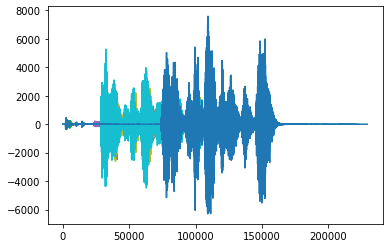

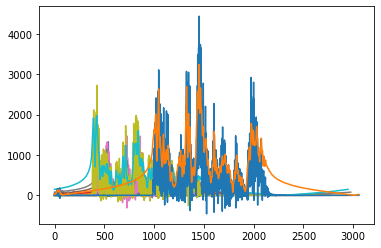

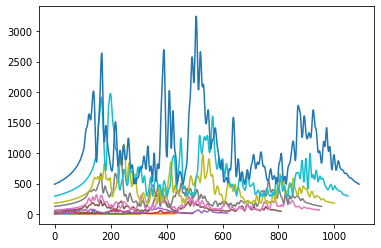

In [50]:
for volume in input_volumes:
    file_name = 'voiceLevels/ronak-'+str(volume)+'.wav'
    data, rate = voice_input(file_name)
    new_volume = getting_loudness3(data, rate)
    result_volume.append(new_volume)


In [51]:
input_volumes, result_volume

([1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80],
 [-29.81731758416708,
  -13.863768966114037,
  -15.354870415091908,
  -21.405723515029955,
  -15.191935452094553,
  -8.87501418072431,
  -6.873431140726749,
  -0.8506258395711809,
  2.355199478226648,
  5.986770226605166,
  10.592550424650899])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


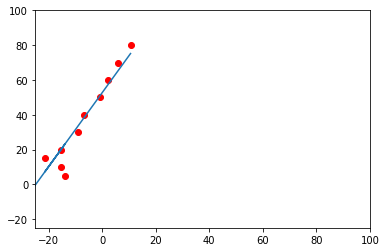

In [52]:
def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c

# plot the actual values
plt.plot(result_volume,input_volumes, 'ro')


#plot the function that overlays them
params = curve_fit(exponenial_func, result_volume, input_volumes, maxfev = 10000)
a,b,c= params[0]
outputs = [ exponenial_func(i,a,b,c) for i in result_volume]
axes = plt.gca()
axes.set_xlim([-25,100])
axes.set_ylim([-25,100])
plt.plot(result_volume, outputs)


In [53]:
import loudness as ln

# All inputs and outputs make use of a SignalBank
inputBank = ln.SignalBank()
nSources = 1
nEars = 1
nChannels = 1
nSamples = 1
fs = 1

# There are 4 dimensions
inputBank.initialize(nSources, nEars, nChannels, nSamples, fs)

# Set the centre frequency of the first channel
inputBank.setCentreFreq(0, 1000)

# Set the intensity in normalised units
level = 40
inputBank.setSample(0, 0, 0, 0, 10.0 ** (level / 10.0))

# The loudness model
model = ln.StationaryLoudnessANSIS342007()
model.initialize(inputBank)

# Now process the input
model.process(inputBank)

# Get the output of this loudness model
feature = 'InstantaneousLoudness'
outputBank = model.getOutput(feature)

print('Loudness in sones %0.2f'+str(outputBank.getSample(0, 0, 0, 0)))

ModuleNotFoundError: No module named 'loudness'

In [ ]:
import pyldb


PLdB = pyldb.perceivedloudness(10, 10, pad_front=10, pad_rear=10)

print(PLdB)